In [1]:
# Librerías
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import t

In [2]:
# Funciones
def OLS_regr(X, Y, **kwargs):
    N = len(X)
    SX = np.sum(X)
    SY = np.sum(Y)
    SXX = np.sum(X*X)
    SYY = np.sum(Y*Y)
    SXY = np.sum(X*Y)

    P1 = SX*SY - N*SXY
    P2 = SX*SXY - SY*SXX
    Q = SX**2 - N*SXX

    a = P1 / Q
    b = P2 / Q

    linear_X = a*X + b
    ji2 = np.sum(np.power(Y - linear_X, 2))

    SE_a = np.sqrt((ji2/(N - 2))*(N/(-Q)))
    SE_b = np.sqrt((ji2/(N - 2))*(SXX/(-Q)))
    r = (-P1)/(np.sqrt((-Q)*(N*SYY - SY**2)))

    if N < 30:
        SE_a *= t.ppf(.975, N - 1)
        SE_b *= t.ppf(.975, N - 1)

    for key, value in kwargs.items():
        if key == 'Delta_X':
            Delta_X = value
            continue
        elif key == 'Delta_Y':
            Delta_Y = value
            continue
    try:
        Delta_X
        Delta_Y
    except NameError:
        return a, b, SE_a, SE_b, r
    else:
        Delta_SX = np.sqrt(np.sum(np.power(Delta_X, 2)))
        Delta_SY = np.sqrt(np.sum(np.power(Delta_Y, 2)))
        Delta_SXX = 2 * np.sqrt(np.sum(np.power(X * Delta_X, 2)))
        Delta_SXY = np.sqrt(np.sum(np.power(X * Delta_Y, 2) + np.power(Delta_X * Y, 2)))

        Delta_P1 = np.sqrt((SX * Delta_SY)**2 + (Delta_SX * SY)**2 + (N * Delta_SXY)**2)
        Delta_P2 = np.sqrt((SX * Delta_SXY)**2 + (Delta_SX * SXY)**2 + (SY * Delta_SXX)**2 + (Delta_SY * SXX)**2)
        Delta_Q = np.sqrt(4 * (SX * Delta_SX)**2 + (N * Delta_SXX)**2)

        Delta_a = np.sqrt((Delta_P1 * Q)**2 + (P1 * Delta_Q)**2)
        Delta_b = np.sqrt((Delta_P2 * Q)**2 + (P2 * Delta_Q)**2)

        return a, b, SE_a, SE_b, Delta_a, Delta_b, r


def get_Deltas_x(x, peaks_indeces, main_group, reference_group):
    sigmaL_indeces = peaks_indeces[:, ::3]
    pi_indeces = peaks_indeces[:, 1::3]
    sigmaR_indeces = peaks_indeces[:, 2::3]

    if main_group == 'L':
        main_index = 0
        ref_index = 1
        sigma_indeces = sigmaR_indeces
    elif main_group == 'C':
        main_index = 1
        if reference_group == 'L':
            ref_index = 0
            sigma_indeces = sigmaL_indeces
        elif reference_group == 'R':
            ref_index = 2
            sigma_indeces = sigmaR_indeces
        else:
            raise Exception("Parámetro reference_group no es 'L' o 'R'.")
    elif main_group == 'R':
        main_index = 2
        ref_index = 1
        sigma_indeces = sigmaL_indeces
    else:
        raise Exception("Parámetro main_group no es 'L', 'C' o 'R'.")

    x_pi_a_pi = np.abs(x[pi_indeces[:, main_index]] - x[pi_indeces[:, ref_index]])
    x_pi_a_sigma = np.abs(x[pi_indeces[:, main_index]] - x[sigma_indeces[:, main_index]])

    return x_pi_a_pi, x_pi_a_sigma

In [49]:
# Misc
styles = [
    dict(selector="th", props=[("text-align", "center")]), # Center headers
    dict(selector="td", props=[("text-align", "center")])  # Center data cells
]

In [24]:
# Constantes
Delta_x = 1  # [u.a.l]
Lambda = 643.8 * 1e-9  # [nm]
Delta_Lambda = 0.1 * 1e-9  # [nm]
d = 4.04 * 1e-3  # [mm]
Delta_d = 0.1 * 1e-3  # [mm]

# [fused silica @ Lambda](https://doi.org/10.1364/JOSA.55.001205)
n = 1.456704
Delta_n = 6e-06

# https://pml.nist.gov/cuu/Constants/
h = 6.62607015e-34  # [J s]
c = 299792458  # [m/s]
mu_B_teorico = 9.2740100657e-24  # [J/T]
Delta_mu_B_teorico = 2.9e-33  # [J/T]

In [3]:
# Datos
datos = pd.read_csv('https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Zeeman/datos/data.csv')
datos_array = np.transpose(datos.to_numpy(dtype=np.float64))

x = datos_array[0]  # [u.a.l]
intensidades = datos_array[1:]  # [u.a.lum]
corrientes = np.array([i * 500 + 5000 for i in range(6)],
                      dtype=np.uint16)  # [mA]

B = np.array([336, 365, 385, 407, 424, 437], dtype=np.float64) / 1000  # [T]

In [4]:
# Picos
picos = [find_peaks(Int, prominence=1.58)[0] for Int in intensidades]
idx_picos = np.array(picos)

In [5]:
# Parámetros de las gráficas
colores = ['#2b0100', '#540300', '#800400', '#ab0600', '#d40700', '#ff0a00']
curve_alpha = .3

plt.rcParams.update({
    "text.usetex": True,
    # "text.latex.preamble": r"\usepackage{bm}",
    "font.size": 18,
    # "font.family": "serif"
})

FloatSlider(value=5.0, continuous_update=False, description='Corriente:', max=7.5, min=5.0, step=0.5)

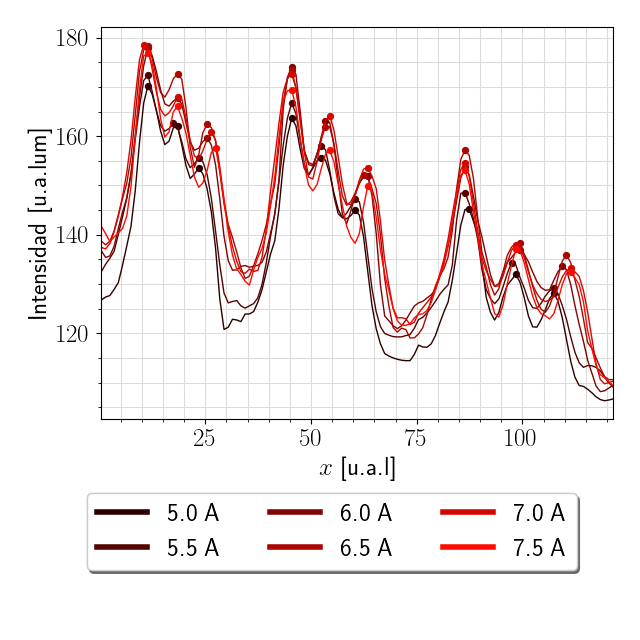

In [23]:
# Gráfica de intensidades contra $x$
plt.close('all')
%matplotlib widget

slider = widgets.FloatSlider(
    value=5,
    min=5,
    max=7.5,
    step=0.5,
    description='Corriente:',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

display(slider)

curves = []
peaks = []
fig, ax = plt.subplots(figsize=(6.4, 6.4))
j = 0
for I_i, pico_i, corriente, color in zip(intensidades, picos, corrientes, colores):
    curves += ax.plot(x, I_i+j, lw=1, label=f'{corriente/1000:.1f} A', c=color)
    idx = pico_i
    peaks.append(ax.scatter(x[idx], I_i[idx]+j, s=18, zorder=2, color=color))
    # j += 6

ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlabel('$x$ [u.a.l]')
ax.set_ylabel('Intensidad [u.a.lum]')
ax.set_xlim([x[-1], x[0]])
leg = ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.45, -0.42),
    ncols=3,
    fancybox=True,
    shadow=True
)
fig.add_artist(leg)
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.tight_layout()
plt.savefig("graficas\\perfiles_de_linea.pdf", format="pdf", bbox_inches='tight')
plt.show()


def select_curve(change):
    selected_val = change['new']
    for i, (curve, peak) in enumerate(zip(curves, peaks)):
        if i == int(selected_val * 2 - 10):
            curve.set_alpha(1)
            peak.set_alpha(1)
        else:
            curve.set_alpha(curve_alpha)
            peak.set_alpha(curve_alpha)
    fig.canvas.draw_idle()


slider.observe(select_curve, names='value')

## Ecuaciones
$$
\boxed{\Delta_\sigma^\pi \lambda = \frac{\Delta_\sigma^\pi x}{\Delta_\pi^\pi x} \frac{\lambda^2}{2 d \sqrt{n^2 - 1}}}
$$
$d = 4.04 \text{ mm}$, $\lambda = 643.8 \text{ nm}$

$$
f = \frac{c}{\lambda} \implies \Delta_\sigma^\pi f = \frac{c \Delta_\sigma^\pi \lambda}{\lambda^2}
$$

$$
\Delta_\sigma^\pi f  = \frac{c \Delta_\sigma^\pi \lambda}{\lambda^2} = \frac{\Delta E}{h} = \frac{\Delta m_l \; \mu_B B}{h} \implies \boxed{\Delta_\sigma^\pi \lambda = \frac{\lambda^2 \Delta m_l \; \mu_B B}{h c}}
$$

## Transformación para la regresión por OLS

De un modelo simple $Y = aX + b$ con

$$
\begin{cases}
X = B \\
Y = \Delta_\sigma^\pi \lambda
\end{cases} \implies
\begin{cases}
a = \frac{\lambda^2 \Delta m_l \; \mu_B}{h c} \\
b \approx 0
\end{cases}
$$

In [40]:
# Determinación de $\Delta_\pi^\pi x$, $\Delta_\sigma^\pi x$ y $\Delta_\sigma^\pi \lambda$
x_pi_a_pi, x_pi_a_sigma = get_Deltas_x(x, idx_picos, 'L', 'C')
Lambda_pi_a_sigma = (x_pi_a_sigma * (Lambda ** 2)) / (x_pi_a_pi * 2 * d * np.sqrt(n ** 2 - 1))
Delta_Lambda_pi_a_sigma = Lambda_pi_a_sigma * np.sqrt(4 * ((1 / (x_pi_a_sigma ** 2) + 1 / (x_pi_a_pi ** 2)) * (Delta_x ** 2) + (Delta_Lambda / Lambda) ** 2) + (Delta_d / d) ** 2 + (n * Delta_n / (n ** 2 - 1)) ** 2)

In [41]:
# Ajuste por OLS y determinación del magnetón de Bohr
# a, b, SE_a, SE_b, r = OLS_regr(X=B, Y=Lambda_pi_a_sigma)
a, b, SE_a, SE_b, r = OLS_regr(X=np.delete(B, 2), Y=np.delete(Lambda_pi_a_sigma, 2))
print(f'        "Slope [m/T]":         "{a:.5e} ± {SE_a:.5e}",')
print(f'        "Intercept [m]":       "{b:.5e} ± {SE_b:.5e}",')
print(f'        "R-squared":           "{r ** 2:.5f}",')

magneton = abs(a) * h * c / Lambda ** 2  # [J/T]
Delta_magneton = SE_a * h * c / Lambda ** 2  # [J/T]

print(f'        "Bohr magneton [J/T]": "{magneton:.5e} ± {Delta_magneton:.5e}",')
print(f'        "Error relativo":      "{abs(magneton - mu_B_teorico) / mu_B_teorico:.2%}"')

        "Slope [m/T]":         "1.96279e-11 ± 1.63378e-11",
        "Intercept [m]":       "4.97453e-12 ± 6.46330e-12",
        "R-squared":           "0.78763",
        "Bohr magneton [J/T]": "9.40696e-24 ± 7.83011e-24",
        "Error relativo":      "1.43%"


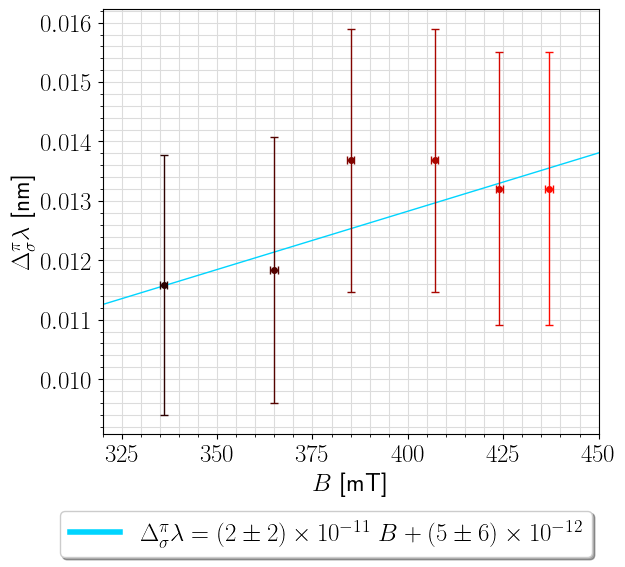

In [43]:
# Gráfica del ajuste para grupo de líneas $m=1$
plt.close('all')
%matplotlib inline

B_ajuste = np.linspace(320, 450, num=50)
Lambda_pi_a_sigma_ajuste = (a * 1e+6) * B_ajuste + (b * 1e+9)

fig, ax = plt.subplots()
for B_i, Lambda_pi_a_sigma_i, Delta_Lambda_i, color in zip(B, Lambda_pi_a_sigma, Delta_Lambda_pi_a_sigma, colores):
    # if color == colores[2]: color = 'goldenrod'
    ax.errorbar(B_i * 1e+3, Lambda_pi_a_sigma_i * 1e+9, yerr=Delta_Lambda_i * 1e+9,
                xerr=1, elinewidth=1, color=color, capsize=3, marker='o', ms=4,
                zorder=3)

regr_label = f'$\\Delta_\\sigma^\\pi \\lambda = ({a * 1e+11:.0f} \\pm {SE_a * 1e+11:.0f}) \\times' + '10^{-11}' + f'\\; B + ({b * 1e+12:.0f} \\pm {SE_b * 1e+12:.0f}) \\times' + '10^{-12}$'
ax.plot(B_ajuste, Lambda_pi_a_sigma_ajuste, c='#00d5ff', lw=1, zorder=2, label=regr_label)

ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlim([320, 450])
ax.set_xlabel(r'$B$ [mT]')
ax.set_ylabel(r'$\Delta_\sigma^\pi \lambda$ [nm]')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True,
                shadow=True, ncol=3, markerscale=1)
for line in leg.get_lines():
    line.set_linewidth(4.0)

# plt.savefig(r"graficas\ajuste_CR.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [51]:
# Recopilación de resultados para diferentes ordenes de difracción
# Tomando Δλ como dλ para hallar Δf
Resultados = {
    'L C': {
        "Slope [m/T]":         "1.84496e-11 ± 2.05728e-11",
        "Intercept [m]":       "5.62932e-12 ± 8.10276e-12",
        "R-squared":           "0.57055",
        "Bohr magneton [J/T]": "8.84221e-24 ± 9.85982e-24",
        "Error relativo":      "4.66%"
    },
    'C L': {
        "Slope [m/T]":         "1.50434e-11 ± 1.98277e-11",
        "Intercept [m]":       "3.57229e-12 ± 7.80928e-12",
        "R-squared":           "0.48743",
        "Bohr magneton [J/T]": "7.20978e-24 ± 9.50271e-24",
        "Error relativo":      "22.26%"
    },
    'C R': {
        "Slope [m/T]":         "2.48956e-11 ± 1.35043e-11",
        "Intercept [m]":       "1.23408e-12 ± 5.31876e-12",
        "R-squared":           "0.84881",
        "Bohr magneton [J/T]": "1.19315e-23 ± 6.47212e-24",
        "Error relativo":      "28.66%"
    },
    'R C': {
        "Slope [m/T]":         "4.51467e-11 ± 1.37785e-11",
        "Intercept [m]":       "-8.10193e-12 ± 5.42676e-12",
        "R-squared":           "0.94663",
        "Bohr magneton [J/T]": "2.16372e-23 ± 6.60354e-24",
        "Error relativo":      "133.31%"
    },
}

slopes_list = []
intercepts_list = []
r_squared_list = []
magneton_list = []
error_relativo_list = []

df = dict()
config_list = ['L C', 'C L', 'C R', 'R C']
report_list = ['Slope [m/T]', 'Intercept [m]', 'R-squared', 'Bohr magneton [J/T]', 'Error relativo']
all_lists = [config_list, slopes_list, intercepts_list, r_squared_list, magneton_list, error_relativo_list]

for key in config_list:
    for report_key, List in zip(report_list, all_lists[1:]):
        List.append(Resultados[key][report_key])
    if key == 'R C': break

for key, List in zip(['Config'] + report_list, all_lists):
    df[key] = List

df = pd.DataFrame(df)
df.index += 1
df = df.style.set_table_styles(styles)
display(df)

,Config,Slope [m/T],Intercept [m],R-squared,Bohr magneton [J/T],Error relativo
1,L C,1.84496e-11 ± 2.05728e-11,5.62932e-12 ± 8.10276e-12,0.57055,8.84221e-24 ± 9.85982e-24,4.66%
2,C L,1.50434e-11 ± 1.98277e-11,3.57229e-12 ± 7.80928e-12,0.48743,7.20978e-24 ± 9.50271e-24,22.26%
3,C R,2.48956e-11 ± 1.35043e-11,1.23408e-12 ± 5.31876e-12,0.84881,1.19315e-23 ± 6.47212e-24,28.66%
4,R C,4.51467e-11 ± 1.37785e-11,-8.10193e-12 ± 5.42676e-12,0.94663,2.16372e-23 ± 6.60354e-24,133.31%


In [63]:
# Tabla de resultados (LC)
Delta_E = h * c * Lambda_pi_a_sigma / (Lambda ** 2)  # [J]
Delta_E_unc = Delta_E * np.sqrt(np.power(Delta_Lambda_pi_a_sigma / Lambda_pi_a_sigma, 2) + (2 * Lambda / Delta_Lambda) ** 2)

df = pd.DataFrame({
    '$I$ [± 0.1 A]': corrientes / 1000,
    '$B$ [± 1 mT]': B * 1e+3,
    '$Δ_σ^π λ$ [nm]': Lambda_pi_a_sigma * 1e+9,
    '$Δ(Δ_σ^π λ)$ [nm]': Delta_Lambda_pi_a_sigma * 1e+9,
    '$ΔE$ [J]': Delta_E,
    '$Δ(Δ E)$ [J]': Delta_E_unc
})
precision_dict = {
    '$I$ [± 0.1 A]': '{:.1f}',
    '$B$ [± 1 mT]': '{:.0f}',
    '$Δ_σ^π λ$ [nm]': '{:.3f}',
    '$Δ(Δ_σ^π λ)$ [nm]': '{:.3f}',
    '$ΔE$ [J]': '{:.0e}',
    '$Δ(Δ E)$ [J]': '{:.0e}'
}

df.index += 1
df.style.set_table_styles(styles).format(precision_dict)
display(df)

,$I$ [± 0.1 A],$B$ [± 1 mT],$Δ_σ^π λ$ [nm],$Δ(Δ_σ^π λ)$ [nm],$ΔE$ [J],$Δ(Δ E)$ [J]
1,5.0,336.0,0.011581,0.002184,5.550171e-24,7.146401e-20
2,5.5,365.0,0.011838,0.002235,5.673509e-24,7.305210e-20
3,6.0,385.0,0.013686,0.002214,6.559294e-24,8.445746e-20
4,6.5,407.0,0.013686,0.002214,6.559294e-24,8.445746e-20
5,7.0,424.0,0.013208,0.002305,6.329948e-24,8.150441e-20
6,7.5,437.0,0.013208,0.002305,6.329948e-24,8.150441e-20
